<a href="https://colab.research.google.com/github/RIDHIJ-19/medical_pytorch/blob/main/version1_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

os.environ["KAGGLE_USERNAME"] = "ridhij19"
os.environ["KAGGLE_KEY"] = "8de4173b2500ad09e457df08090b8dab"

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:23<00:00, 128MB/s]
100% 2.29G/2.29G [00:23<00:00, 106MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip -d chest_xray_pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0442-

In [ ]:
#Importing all the required libraries and frameworks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import os
from PIL import Image
from torchvision.datasets import ImageFolder

#Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
norm_path = Path ("/content/chest_xray_pneumonia/chest_xray/train/NORMAL")
pneu_path = Path("/content/chest_xray_pneumonia/chest_xray/train/PNEUMONIA")

image_paths = []
label_name = []
for file in os.listdir(norm_path):
    image_paths.append(os.path.join(norm_path, file))
    label_name.append("Normal")

for file in os.listdir(pneu_path):
    image_paths.append(os.path.join(pneu_path, file))
    label_name.append("Pneumonia")
print(len(image_paths))

label_df = pd.DataFrame({'label': label_name})
imgpath_df = pd.DataFrame({'image_paths' :image_paths })
# if that's what you want.
df = pd.concat([label_df , imgpath_df ], axis=1)

data = df.sample(frac=1, random_state=42)
data = data.reset_index(drop=True)

print(data)

test_norm_path = Path("/content/chest_xray_pneumonia/chest_xray/test/NORMAL")
test_pneu_path = Path("/content/chest_xray_pneumonia/chest_xray/test/PNEUMONIA")

test_image_paths = []
test_label_name = []
for file in os.listdir(test_norm_path):
    test_image_paths.append(os.path.join(test_norm_path, file))
    test_label_name.append("Normal")

for file in os.listdir(test_pneu_path):
    test_image_paths.append(os.path.join(test_pneu_path, file))
    test_label_name.append("Pneumonia")
print(len(test_image_paths))

test_label_df = pd.DataFrame({'label': test_label_name})
test_imgpath_df = pd.DataFrame({'image_paths' :test_image_paths })
# if that's what you want.
test_df = pd.concat([test_label_df , test_imgpath_df ], axis=1)

test = test_df.sample(frac=1, random_state=42)
test = test.reset_index(drop=True)

print(test)

5216
          label                                        image_paths
0     Pneumonia  /content/chest_xray_pneumonia/chest_xray/train...
1        Normal  /content/chest_xray_pneumonia/chest_xray/train...
2     Pneumonia  /content/chest_xray_pneumonia/chest_xray/train...
3     Pneumonia  /content/chest_xray_pneumonia/chest_xray/train...
4     Pneumonia  /content/chest_xray_pneumonia/chest_xray/train...
...         ...                                                ...
5211     Normal  /content/chest_xray_pneumonia/chest_xray/train...
5212  Pneumonia  /content/chest_xray_pneumonia/chest_xray/train...
5213  Pneumonia  /content/chest_xray_pneumonia/chest_xray/train...
5214  Pneumonia  /content/chest_xray_pneumonia/chest_xray/train...
5215     Normal  /content/chest_xray_pneumonia/chest_xray/train...

[5216 rows x 2 columns]
624
         label                                        image_paths
0    Pneumonia  /content/chest_xray_pneumonia/chest_xray/test/...
1    Pneumonia  /content/chest

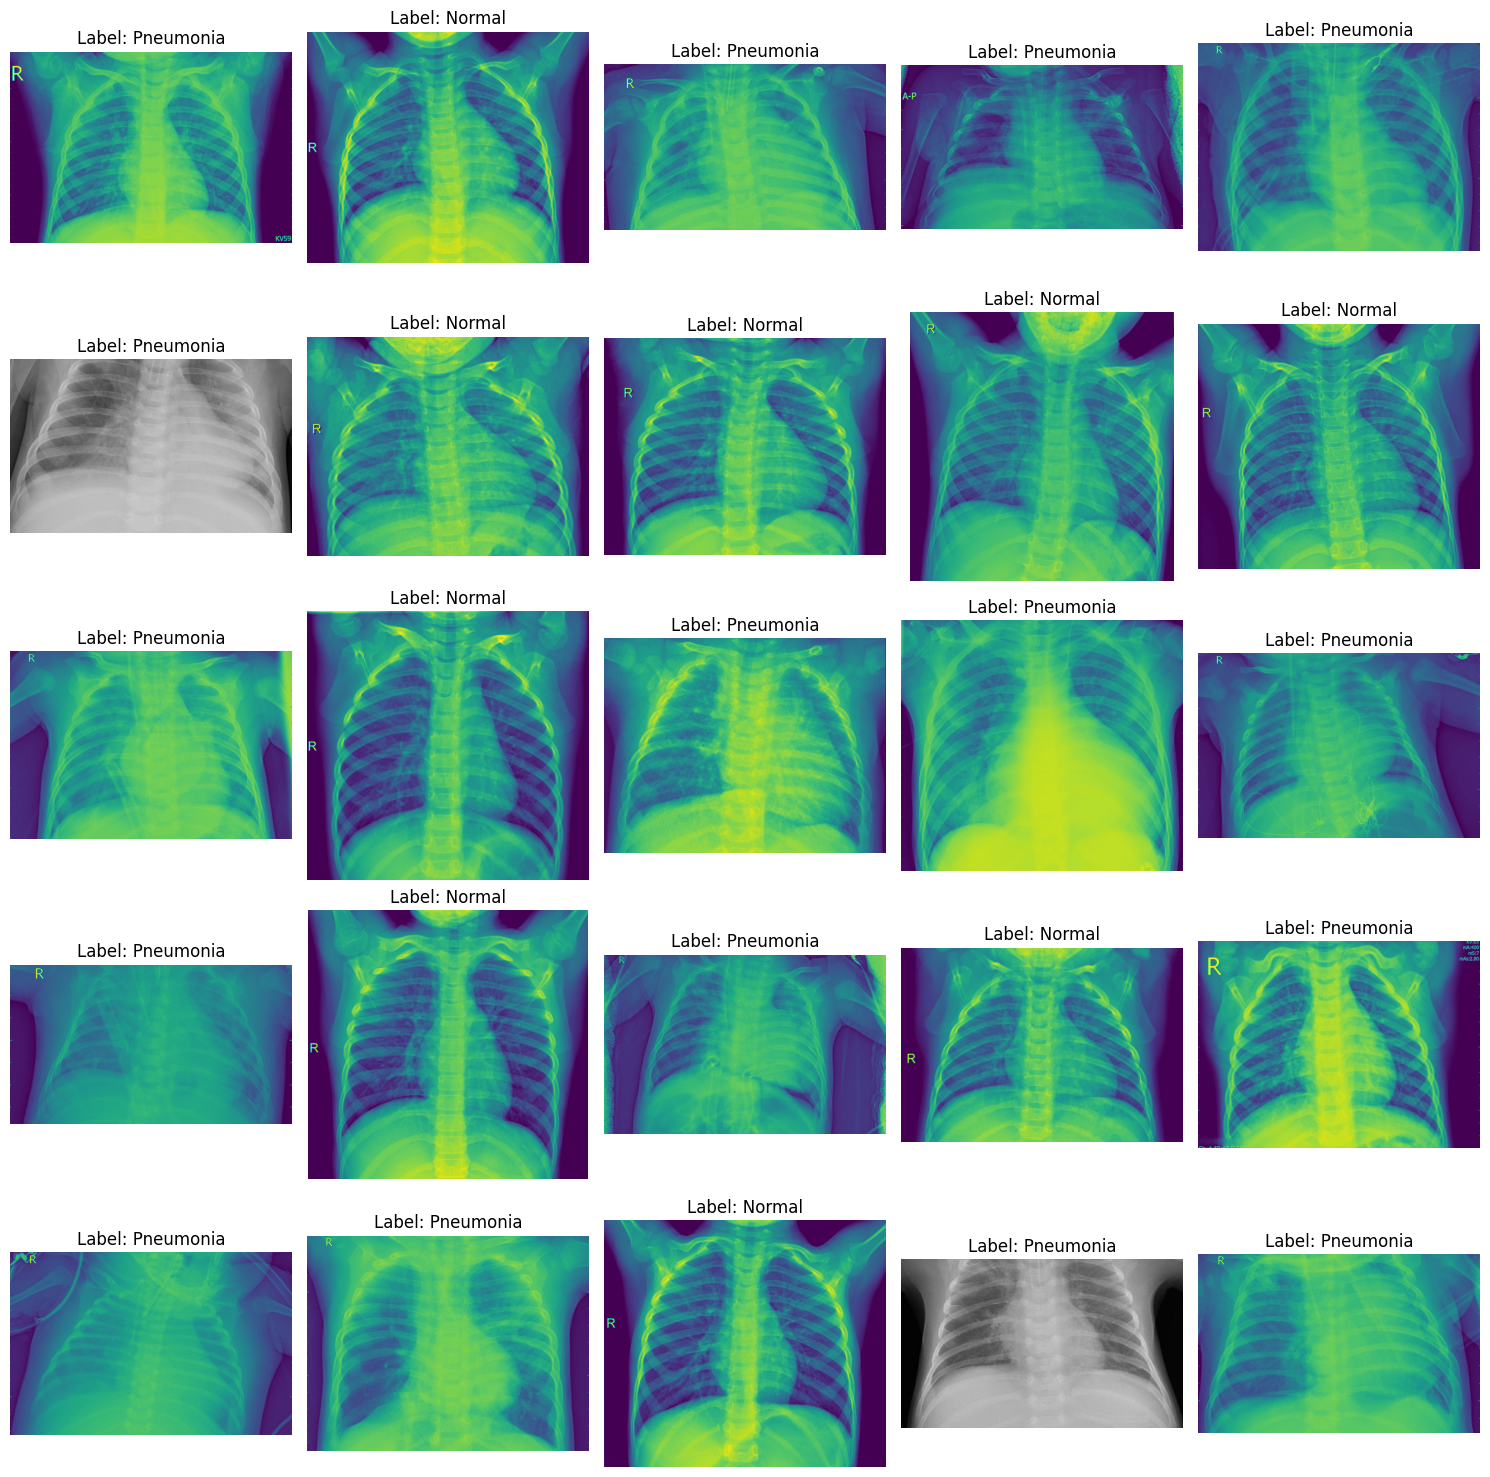

In [ ]:
fig, axes = plt.subplots(5 , 5, figsize=(15, 15))
for i in range(25):
    row = i // 5
    col = i % 5
    image_path = data['image_paths'][i]
    img = Image.open(image_path)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Label: {data['label'][i]}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
# Data Normalisation
data_dir = '/content/chest_xray_pneumonia/chest_xray'
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                 for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training 3 Different Pre-Trained Models
#model1 : ResNet
model1 = models.resnet18(pretrained=True)
num_ftrs = model1.fc.in_features
model1.fc = nn.Linear(num_ftrs, 2) # 2 is the number of classes

#model2 : VGG16
model2 = models.vgg16(pretrained=True)
model2.classifier[6] = torch.nn.Linear(4096, 2)

#model3 : DenseNet
model3 = models.densenet121(pretrained=True)
model3.classifier = torch.nn.Linear(1024, 2)

model_list = {'ResNet' : model1, 'VGG16' : model2, 'DenseNet' : model3}

for name, model in model_list.items():
    print('{} Model Training'.format(name))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(5):
        for phase in ['train']:
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('Epoch: {} Loss: {:.4f} Acc: {:.4f} %'.format(epoch + 1, epoch_loss, epoch_acc * 100))

print('Training completed')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can als

ResNet Model Training
Epoch: 1 Loss: 0.3811 Acc: 83.7423 %
Epoch: 2 Loss: 0.2948 Acc: 89.0529 %
Epoch: 3 Loss: 0.2704 Acc: 90.4716 %
Epoch: 4 Loss: 0.2452 Acc: 91.1043 %
Epoch: 5 Loss: 0.2297 Acc: 92.1779 %
VGG16 Model Training
Epoch: 1 Loss: 0.3214 Acc: 86.3689 %
Epoch: 2 Loss: 0.2249 Acc: 90.9701 %
Epoch: 3 Loss: 0.2015 Acc: 91.7753 %
Epoch: 4 Loss: 0.1835 Acc: 92.6572 %
Epoch: 5 Loss: 0.1594 Acc: 93.9034 %
DenseNet Model Training
Epoch: 1 Loss: 0.3697 Acc: 84.4133 %
Epoch: 2 Loss: 0.3136 Acc: 88.1902 %
Epoch: 3 Loss: 0.2589 Acc: 90.7400 %
Epoch: 4 Loss: 0.2455 Acc: 91.1426 %
Epoch: 5 Loss: 0.2194 Acc: 92.1204 %
Training completed


In [ ]:
import torch.optim as optim
# Data Normalisation
data_dir = '/content/chest_xray_pneumonia/chest_xray'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define a transform to augment the data
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.ImageFolder(root='/content/chest_xray_pneumonia/chest_xray/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('NORMAL', 'PNEUMONIA',)
for name, model in model_list.items():
    net = model
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the {} model on the test images: {} %'.format(name, 100 * correct / total))

Accuracy of the ResNet model on the test images: 67.78846153846153 %
Accuracy of the VGG16 model on the test images: 69.07051282051282 %
Accuracy of the DenseNet model on the test images: 75.16025641025641 %


confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

for name, model in model_list.items():
    net = model
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        all_predictions = []
        all_labels = []

        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)

            # Update the correct count
            correct += (predicted == labels).sum().item()

            # Append predictions and labels to the lists
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)

        # Calculate and print accuracy
        accuracy = 100 * correct / total
        print('Accuracy of the {} model on the test images: {:.2f} %'.format(name, accuracy))

        # Calculate and print the confusion matrix
        confusion_matrix_result = confusion_matrix(all_labels, all_predictions)
        print(f'Confusion Matrix for {name}:')
        print(confusion_matrix_result)


Accuracy of the ResNet model on the test images: 67.79 %
Confusion Matrix for ResNet:
[[ 33 201]
 [  0 390]]
Accuracy of the VGG16 model on the test images: 69.07 %
Confusion Matrix for VGG16:
[[ 42 192]
 [  1 389]]
Accuracy of the DenseNet model on the test images: 75.16 %
Confusion Matrix for DenseNet:
[[ 80 154]
 [  1 389]]


Accuracy of the ResNet model on the test images: 67.79 %


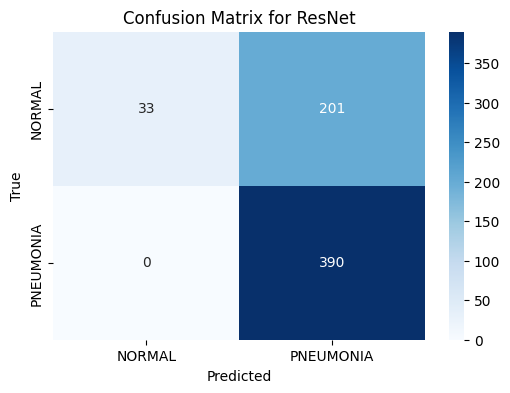

Accuracy of the VGG16 model on the test images: 69.07 %


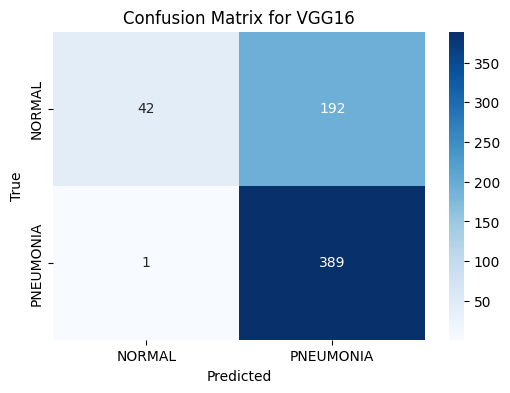

Accuracy of the DenseNet model on the test images: 75.16 %


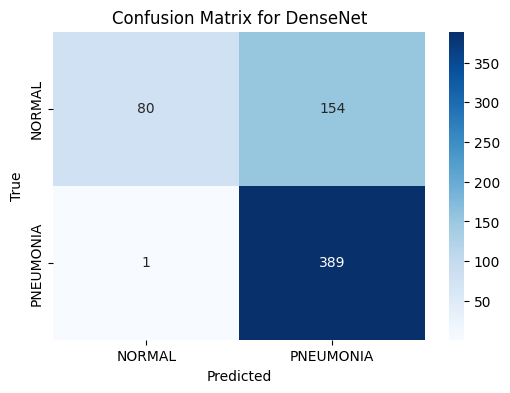

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for name, model in model_list.items():
    net = model
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        all_predictions = []
        all_labels = []

        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)

        accuracy = 100 * correct / total
        print('Accuracy of the {} model on the test images: {:.2f} %'.format(name, accuracy))

        confusion_matrix_result = confusion_matrix(all_labels, all_predictions)

        # Create a heatmap of the confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_matrix_result, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix for {name}')
        plt.show()
